In [1]:
import cv2
import glob
import os
import pandas as pd
import numpy as np
import subprocess

# general imports
from copy import deepcopy
from pathlib import Path
from scipy.signal import resample

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, MSELoss, SmoothL1Loss
from torch.optim import Adam, SGD, lr_scheduler, LBFGS, RAdam, AdamW
from torch.utils.data import DataLoader
from torchmetrics import PeakSignalNoiseRatio
#from adabelief_pytorch import AdaBelief
#from torchviz import make_dot

In [2]:
def generate_cdr1_to_cdr3_pdb(path):
    with open(path, 'r') as f: # needs to be Chothia-numbered
        content = f.readlines()
        header_lines_important = range(4)
        header_lines = [content[i][0]=='R' for i in range(len(content))].count(True)
        h_range = range(26, 103)
        l_range = range(24, 98)
        chain_range = slice(21, 22)
        res_range = slice(23, 26)
        h_chain_key = 'HCHAIN'
        l_chain_key = 'LCHAIN'
        idx_list = list(header_lines_important)
        new_path = path[:-4] + '_CDR1_to_CDR3' + path[-4:]
        
        # Getting the names of the heavy and light chains
        line = content[header_lines_important[-1]]
        if line.find(h_chain_key) != -1:
            h_pos = line.find(h_chain_key) + len(h_chain_key) + 1
            l_pos = line.find(l_chain_key) + len(l_chain_key) + 1
            h_chain = line[h_pos:h_pos+1]
            l_chain = line[l_pos:l_pos+1]
            
            # Obtaining the CDR1 to CDR3 lines for both chains
            for i, line in enumerate(content[header_lines:]):
                if (line[chain_range].find(h_chain) != -1 and int(line[res_range]) in h_range) or (line[chain_range].find(l_chain) != -1 and int(line[res_range]) in l_range):
                    idx_list.append(i+header_lines)
            
                    
    # Creating new file
    with open(new_path, 'w') as f_new:
        f_new.writelines([content[l] for l in idx_list])

In [3]:
# Getting entries with affinity and antigen information
df = pd.read_csv('sabdab_summary_all.tsv', sep='\t', header=0)[['pdb', 'antigen_type', 'affinity']]
df.drop_duplicates(keep='first', inplace=True)
df = df[(df.antigen_type.notna()) & (df.antigen_type != 'NA')][['pdb', 'affinity']]
df = df[(df.affinity.notna()) & (df.affinity != 'None')]
entries = list(df['pdb'])
affinity = list(df['affinity'])
modes = 15 # 'all' if no limit is desired, otherwise a number is required
numbering = ''
selection = '_CDR1_to_CDR3'
folder = str(Path.home() / 'Downloads') + '/all_structures/chothia/'
file_type_input = '.pdb'
dccm_map_path = 'dccm_maps/'

# Uncomment to generate
#for entry in entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input)
#    subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))
    
#    if os.path.exists(path):
#        os.remove(path)

In [4]:
# Uncomment to get the lengths of the light and heavy chains
dccm_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))
selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]
heavy = np.load('chain_lengths/heavy_lengths.npy')
light = np.load('chain_lengths/light_lengths.npy')


#heavy = []
#light = []

#for entry in selected_entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input)
#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
    
#    if os.path.exists(path):
#        os.remove(path)
#    h, l = np.load('/Users/kevinmicha/Downloads/value.npy') # there might be a neat solution

#    heavy.append(h)
#    light.append(l)

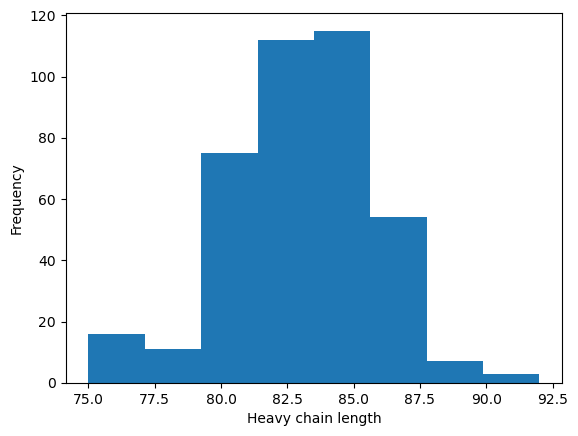

In [5]:
plt.hist(heavy, 8)
plt.xlabel('Heavy chain length')
plt.ylabel('Frequency')
plt.show()

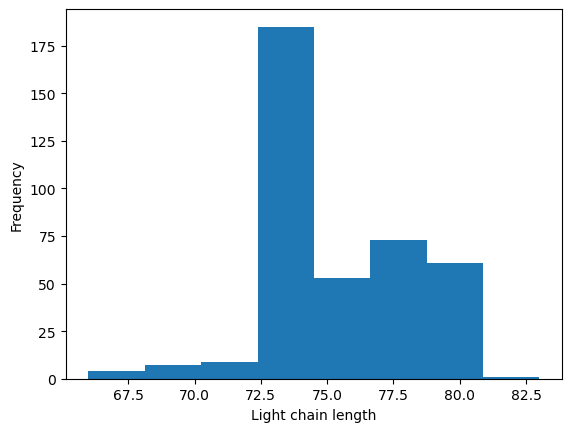

In [6]:
plt.hist(light, 8)
plt.xlabel('Light chain length')
plt.ylabel('Frequency')
plt.show()

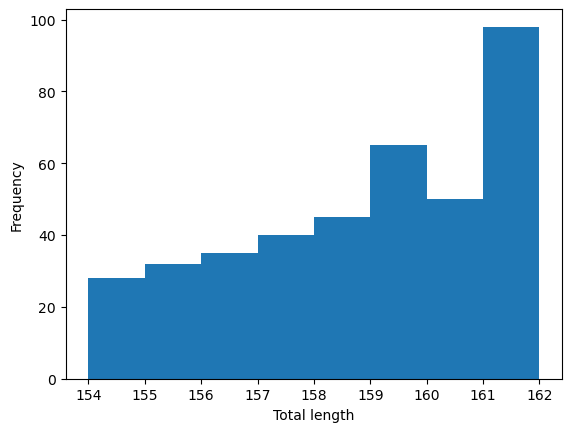

In [7]:
plt.hist([sum(x) for x in zip(heavy, light)], 8)
plt.xlabel('Total length')
plt.ylabel('Frequency')
plt.show()

In [8]:
# loading training images
imgs = []
kds = []
labels = []
data_path = '/Users/kevinmicha/Documents/PhD/predicting-affinity/' + dccm_map_path
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
for f in file_paths:
    pdb_id = f[-8:-4]
    if pdb_id in selected_entries:
        idx = selected_entries.index(pdb_id)
        labels.append(pdb_id)
        imgs.append(cv2.resize(np.load(f)[:heavy[idx], :heavy[idx]], dsize=(80, 80)))
        kds.append(np.log10(np.float32(affinity[idx])))

# converting the list to numpy array
#train_x = np.array(np.triu(imgs))
train_x = np.array(imgs)
# defining the target
train_y = np.array(kds)

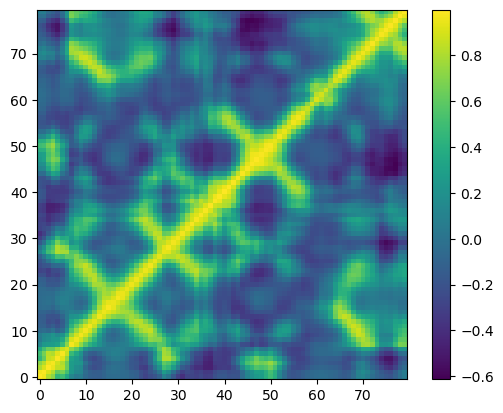

In [9]:
plt.imshow(train_x[15].reshape(train_x.shape[-1], train_x.shape[-1]), origin='lower')
plt.colorbar()

In [10]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.0001)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((392, 80, 80), (392,)), ((1, 80, 80), (1,)))

In [11]:
# converting training images into torch format
train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[1])
train_x = train_x.astype(np.float32)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(np.float32).reshape(train_y.shape[0], 1)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([392, 1, 80, 80]), torch.Size([392, 1]))

In [12]:
len(list(train_x))

392

In [13]:
# converting validation images into torch format
val_x = val_x.reshape(val_x.shape[0], 1, train_x.shape[2], train_x.shape[2])
val_x = val_x.astype(np.float32)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(np.float32).reshape(val_y.shape[0], 1)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([1, 1, 80, 80]), torch.Size([1, 1]))

In [32]:
class MultiLabelNN(Module):
    def __init__(self):
        super(MultiLabelNN, self).__init__()
        self.conv1 = Conv2d(1, 8, 21)
        self.conv1.weight.data = torch.tril(self.conv1.weight.data) + torch.transpose(torch.tril(self.conv1.weight.data), 2, 3)
        #self.conv1.weight.data = torch.transpose(self.conv1.weight.data, 2, 3)
        self.pool = MaxPool2d(4, 4)
        self.conv2 = Conv2d(16, 32, 3)
        self.conv2.weight.data = torch.tril(self.conv2.weight.data) + torch.transpose(torch.tril(self.conv2.weight.data), 2, 3)
        #self.conv2.weight.data = torch.transpose(self.conv2.weight.data, 2, 3)
        self.relu = ReLU()
        self.fc1 = Linear(1800, 1)
        self.fc2 = Linear(128, 1)
        self.dropit = Dropout(p=0.05)
        #self.fc3 = Linear(128, 64)
        #self.fc4 = Linear(64, 1)

    def forward(self, x):
       #shape of x is (b_s, 32,32,1)
        x = self.conv1(x) + torch.transpose(self.conv1(x), 2, 3)#shape of x is (b_s, 28,28,132)
        x = self.relu(x)
        x = self.pool(x) #shape of x now becomes (b_s X 14 x 14 x 32)
        #x = self.conv2(x) # shape(b_s, 10x10x64)
        #x = self.relu(x)#size is (b_s x 10 x 10 x 64)
        x = x.view(x.size(0), -1) # shape of x is now(b_s*2, 3200)
        #this is the problem 
        #you can fc1 to be of shape (6400,1024) and that will work 
        x = self.fc1(x)
        #x = self.dropit(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        #x = self.relu(x)
        #x = self.fc3(x)
        #x = self.relu(x)
        #x = self.fc4(x)


        return x.float()


In [33]:
# defining the model
model = MultiLabelNN()
# defining the optimizer
optimizer = AdamW(model.parameters(), lr=4e-4)
#optimizer = AdaBelief(model.parameters(), lr=5e-5, eps=1e-16, betas=(0.9,0.999), weight_decouple=False, rectify=False)
#optimizer = SGD(model.parameters(), lr=8e-4)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, min_lr=3e-8, factor=1e-4)
# defining the loss function
criterion = MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

MultiLabelNN(
  (conv1): Conv2d(1, 8, kernel_size=(21, 21), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (fc1): Linear(in_features=1800, out_features=1, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropit): Dropout(p=0.05, inplace=False)
)


In [34]:
def train(epoch):
    model.train()
    tr_loss = 0
    batch_size = 32
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)

    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    
    permutation = torch.randperm(x_train.size()[0])

    for i in range(0, x_train.size()[0], batch_size):
        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        
        # prediction for training and validation set
        output_train = model(batch_x)
        output_val = model(x_val)

        # computing the training and validation loss
        loss_train = criterion(output_train, batch_y)
        loss_val = criterion(output_val, y_val)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
        
        #scheduler.step(loss_val)
        tr_loss += loss_train.item() * batch_size / x_train.size()[0]
    train_losses.append(tr_loss)
    val_losses.append(loss_val)
    
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'train loss: ', tr_loss, 'val loss :', loss_val)
    print(output_val)
    print(y_val)
        
    return tr_loss, loss_val


In [35]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

In [ ]:
# defining the number of epochs
n_max_epochs = 2000

# training the model
for epoch in range(n_max_epochs):
    tr_loss, val_loss = train(epoch)
    if tr_loss < 0.2 and val_loss < 0.1:
        break

Epoch :  1 	 train loss:  2.4105248499889766 val loss : tensor(0.1463, grad_fn=<MseLossBackward0>)
tensor([[-7.3298]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  2 	 train loss:  2.2620501810190627 val loss : tensor(0.0111, grad_fn=<MseLossBackward0>)
tensor([[-7.6068]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  3 	 train loss:  2.3149822293495648 val loss : tensor(0.0656, grad_fn=<MseLossBackward0>)
tensor([[-7.9683]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  4 	 train loss:  2.306824893367534 val loss : tensor(0.0287, grad_fn=<MseLossBackward0>)
tensor([[-7.5427]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  5 	 train loss:  2.2141430329303353 val loss : tensor(0.0292, grad_fn=<MseLossBackward0>)
tensor([[-7.5412]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  6 	 train loss:  2.281440939222063 val loss : tensor(0.0818, grad_fn=<MseLossBackward0>)
tensor([[-7.4263]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  7 	

Epoch :  51 	 train loss:  1.957734288001547 val loss : tensor(0.0649, grad_fn=<MseLossBackward0>)
tensor([[-7.9669]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  52 	 train loss:  2.017236417653609 val loss : tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor([[-7.6679]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  53 	 train loss:  2.0007955979327763 val loss : tensor(0.0401, grad_fn=<MseLossBackward0>)
tensor([[-7.5119]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  54 	 train loss:  2.0748088895058143 val loss : tensor(0.0468, grad_fn=<MseLossBackward0>)
tensor([[-7.4958]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  55 	 train loss:  1.9471282472415847 val loss : tensor(0.1020, grad_fn=<MseLossBackward0>)
tensor([[-8.0316]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  56 	 train loss:  1.9664806735758877 val loss : tensor(0.0710, grad_fn=<MseLossBackward0>)
tensor([[-7.9787]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch 

Epoch :  101 	 train loss:  1.808924674987793 val loss : tensor(0.3710, grad_fn=<MseLossBackward0>)
tensor([[-8.3213]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  102 	 train loss:  1.9086625965274109 val loss : tensor(0.4566, grad_fn=<MseLossBackward0>)
tensor([[-8.3879]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  103 	 train loss:  1.8106850604621736 val loss : tensor(0.0913, grad_fn=<MseLossBackward0>)
tensor([[-8.0144]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  104 	 train loss:  1.7512528750361227 val loss : tensor(0.1374, grad_fn=<MseLossBackward0>)
tensor([[-8.0829]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  105 	 train loss:  1.787791145091154 val loss : tensor(0.1922, grad_fn=<MseLossBackward0>)
tensor([[-8.1506]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  106 	 train loss:  1.7799654797631868 val loss : tensor(0.3428, grad_fn=<MseLossBackward0>)
tensor([[-8.2977]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])


Epoch :  151 	 train loss:  1.8438122515775721 val loss : tensor(0.8641, grad_fn=<MseLossBackward0>)
tensor([[-8.6418]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  152 	 train loss:  1.7441969112474094 val loss : tensor(0.6689, grad_fn=<MseLossBackward0>)
tensor([[-8.5301]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  153 	 train loss:  1.599534983537635 val loss : tensor(0.4396, grad_fn=<MseLossBackward0>)
tensor([[-8.3752]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  154 	 train loss:  1.8009717610417582 val loss : tensor(0.1964, grad_fn=<MseLossBackward0>)
tensor([[-8.1554]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  155 	 train loss:  1.8723509846901407 val loss : tensor(0.0300, grad_fn=<MseLossBackward0>)
tensor([[-7.8854]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  156 	 train loss:  1.6154977934701102 val loss : tensor(0.4766, grad_fn=<MseLossBackward0>)
tensor([[-8.4026]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])

Epoch :  201 	 train loss:  1.5826183387211392 val loss : tensor(0.1975, grad_fn=<MseLossBackward0>)
tensor([[-8.1566]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  202 	 train loss:  1.5174570424216134 val loss : tensor(0.3409, grad_fn=<MseLossBackward0>)
tensor([[-8.2961]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  203 	 train loss:  1.552533757929899 val loss : tensor(0.1954, grad_fn=<MseLossBackward0>)
tensor([[-8.1543]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  204 	 train loss:  1.4904138847273223 val loss : tensor(0.3070, grad_fn=<MseLossBackward0>)
tensor([[-8.2663]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  205 	 train loss:  1.5352483914822947 val loss : tensor(0.9303, grad_fn=<MseLossBackward0>)
tensor([[-8.6767]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  206 	 train loss:  1.7097618433893942 val loss : tensor(0.9062, grad_fn=<MseLossBackward0>)
tensor([[-8.6641]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])

Epoch :  251 	 train loss:  1.4033661472554109 val loss : tensor(0.7871, grad_fn=<MseLossBackward0>)
tensor([[-8.5994]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  252 	 train loss:  1.3607646056583949 val loss : tensor(0.5553, grad_fn=<MseLossBackward0>)
tensor([[-8.4574]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  253 	 train loss:  1.4190580358310623 val loss : tensor(0.7331, grad_fn=<MseLossBackward0>)
tensor([[-8.5684]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  254 	 train loss:  1.449787864879686 val loss : tensor(1.3924, grad_fn=<MseLossBackward0>)
tensor([[-8.8922]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  255 	 train loss:  1.5446489003239845 val loss : tensor(1.1882, grad_fn=<MseLossBackward0>)
tensor([[-8.8023]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  256 	 train loss:  1.4195673854983584 val loss : tensor(0.7049, grad_fn=<MseLossBackward0>)
tensor([[-8.5518]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])

Epoch :  301 	 train loss:  1.3131724766322543 val loss : tensor(0.6308, grad_fn=<MseLossBackward0>)
tensor([[-8.5064]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  302 	 train loss:  1.324904762968725 val loss : tensor(0.3841, grad_fn=<MseLossBackward0>)
tensor([[-8.3320]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  303 	 train loss:  1.4072735406914536 val loss : tensor(0.7762, grad_fn=<MseLossBackward0>)
tensor([[-8.5932]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  304 	 train loss:  1.3711813566636066 val loss : tensor(0.2715, grad_fn=<MseLossBackward0>)
tensor([[-8.2332]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  305 	 train loss:  1.2474317210061208 val loss : tensor(1.0179, grad_fn=<MseLossBackward0>)
tensor([[-8.7211]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  306 	 train loss:  1.4218167577471053 val loss : tensor(0.7015, grad_fn=<MseLossBackward0>)
tensor([[-8.5497]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])

Epoch :  351 	 train loss:  1.4099297231557417 val loss : tensor(1.2447, grad_fn=<MseLossBackward0>)
tensor([[-8.8279]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  352 	 train loss:  1.263153854681521 val loss : tensor(0.7127, grad_fn=<MseLossBackward0>)
tensor([[-8.5564]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  353 	 train loss:  1.4079200929524947 val loss : tensor(0.2048, grad_fn=<MseLossBackward0>)
tensor([[-8.1647]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  354 	 train loss:  1.2359854055910695 val loss : tensor(1.6322, grad_fn=<MseLossBackward0>)
tensor([[-8.9898]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  355 	 train loss:  1.1682711791019054 val loss : tensor(0.5203, grad_fn=<MseLossBackward0>)
tensor([[-8.4335]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])
Epoch :  356 	 train loss:  1.210364409855434 val loss : tensor(0.5943, grad_fn=<MseLossBackward0>)
tensor([[-8.4831]], grad_fn=<AddmmBackward0>)
tensor([[-7.7122]])


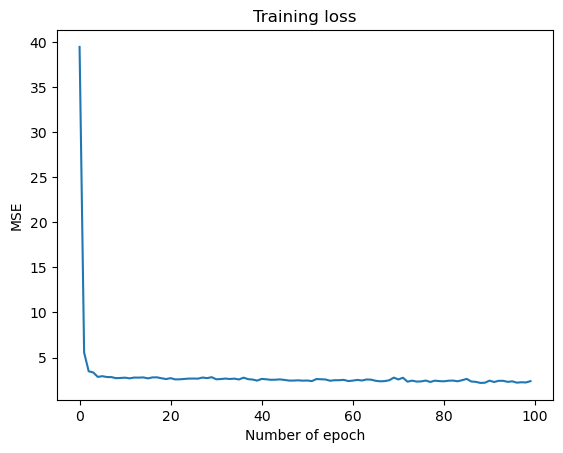

In [37]:
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

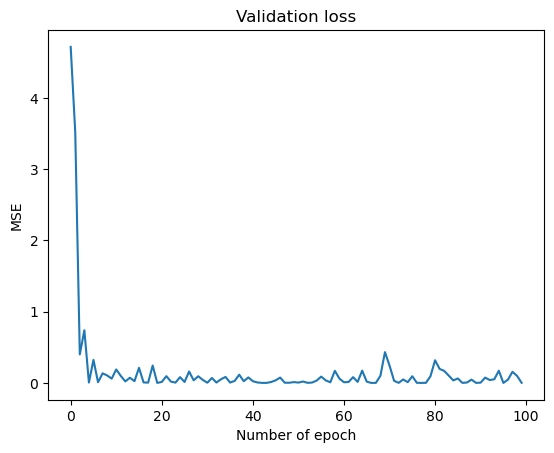

In [38]:
plt.plot([val_losses[i].detach().numpy() for i in range(len(val_losses))])
plt.title('Validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

In [39]:
model.eval()
model(Variable(train_x[15:20]))

tensor([[-8.4416],
        [-8.1708],
        [-8.8159],
        [-8.0439],
        [-8.8192]], grad_fn=<AddmmBackward0>)

In [40]:
Variable(train_y[15:20])

tensor([[-6.0888],
        [-8.7959],
        [-8.2518],
        [-7.4559],
        [-7.5186]])

In [41]:
file_paths

['/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1a4k.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1axs.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bj1.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bvk.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1c12.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1ct8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1cz8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1d6v.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dbb.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dee.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dl7.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1e6j.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1eo8.npy',
 '/Users/kevinmicha/Docum

In [42]:
download_path = '/Users/kevinmicha/Downloads/' # or data_path

test_sample = torch.from_numpy(cv2.resize(np.load(download_path + '1t66.npy')[:82, :82], dsize=(80, 80)).reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))

In [43]:
model.eval()
10**model(test_sample).detach().numpy()

array([[6.410268e-10]], dtype=float32)

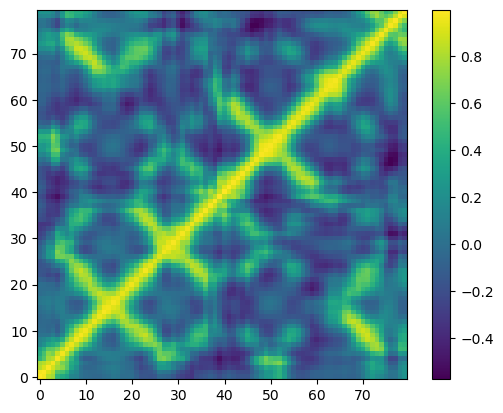

In [44]:
plt.imshow(test_sample[0,0,...], origin='lower')
plt.colorbar()

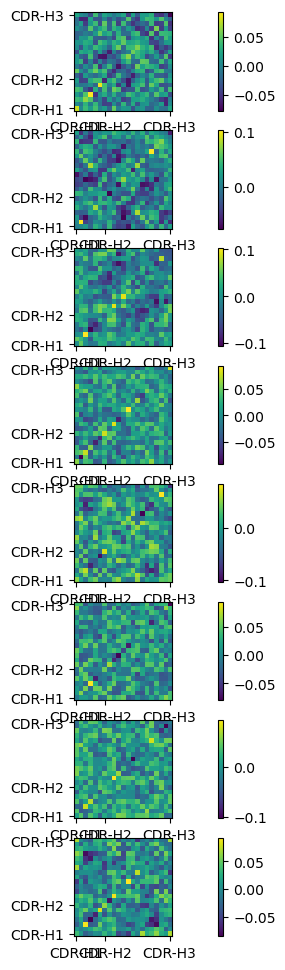

In [45]:
import itertools

fig, axs = plt.subplots(8, 1, figsize=(12, 12))
conv_filters = deepcopy(model.conv1.weight.data.numpy())
                           
for i, j in itertools.product(range(8), range(1)):
    im = axs[i].imshow(conv_filters[i+j][0], origin='lower')
    axs[i].set_xticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])

In [46]:
#fig, axs = plt.subplots(8, 4, figsize=(12, 12))

#for i, j in itertools.product(range(8), range(4)):
#    im = axs[i,j].imshow(model.conv2.weight.data.numpy()[i+j][0], origin='lower')
#    plt.colorbar(im, ax=axs[i, j])


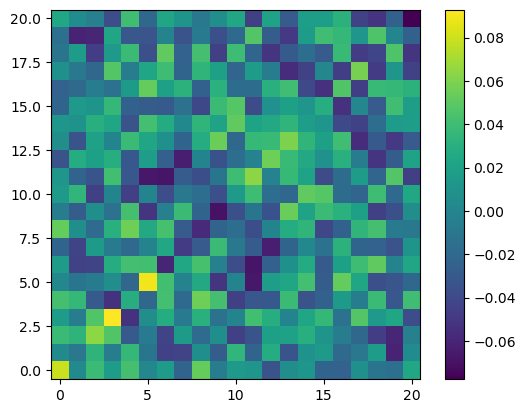

In [47]:
plt.imshow(np.mean(conv_filters[0,...], axis=0), origin='lower')
plt.colorbar()

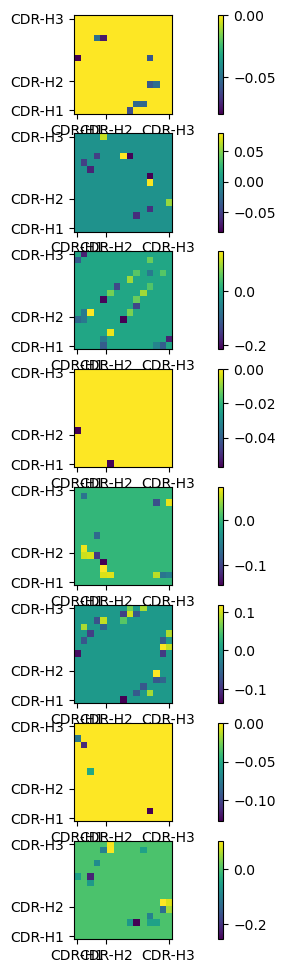

In [48]:
fig, axs = plt.subplots(8, 1, figsize=(12, 12))

fully_connected = deepcopy(model.fc1.weight.data.numpy().reshape(8, 225))
fully_connected = np.where(abs(fully_connected)<0.05, 0, fully_connected)

for i, j in itertools.product(range(8), range(1)):
    im = axs[i].imshow(fully_connected[i].reshape(15, 15), origin='lower')
    axs[i].set_xticks([0, 4.5, 14], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 4.5, 14], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])


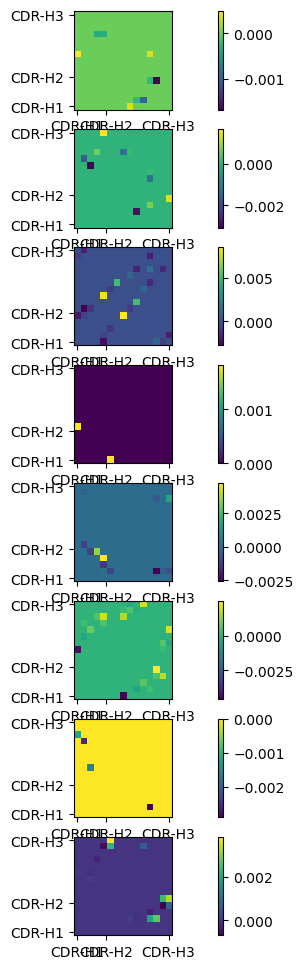

In [49]:
fig, axs = plt.subplots(8, 1, figsize=(12, 12))

img = np.zeros((15, 15))
for i, j in itertools.product(range(8), range(1)):
    new_img = np.multiply(cv2.resize(conv_filters[i,0,...], dsize=(15, 15), interpolation=cv2.INTER_AREA), fully_connected[i].reshape(15, 15))
    im = axs[i].imshow(new_img, origin='lower')
    axs[i].set_xticks([0, 4.5, 14], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 4.5, 14], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])
    img += new_img



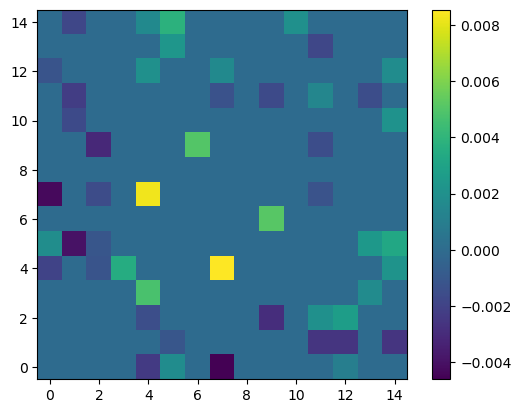

In [56]:
#blue = "need blue in dccm"
#yellow = "need red in dccm"
plt.imshow(np.where(abs(img)<0.001, 0, img), origin='lower')
plt.colorbar()
plt.show()

In [57]:
img.sum()

0.019346587956533767

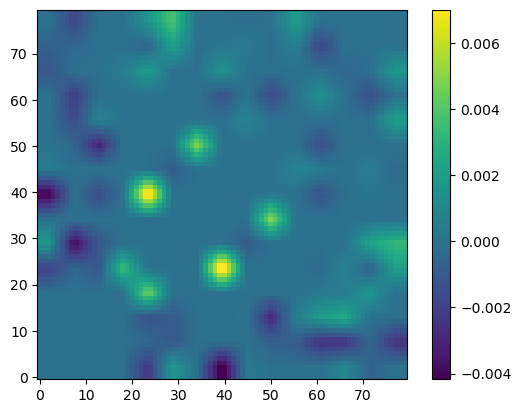

In [58]:
plt.imshow(cv2.resize(img, dsize=(80, 80)), origin='lower')
plt.colorbar()

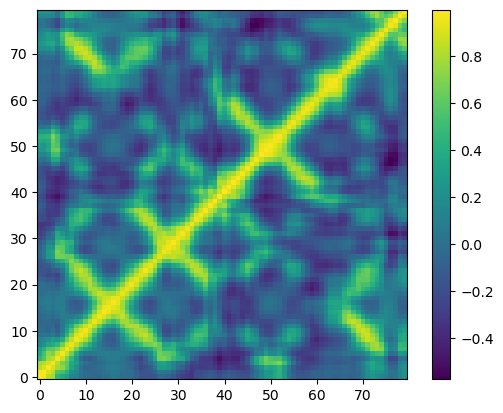

In [59]:
# 1.1303e-05 without adding map
ideal = cv2.resize(np.load(download_path + '1t66.npy')[:82, :82], dsize=(80, 80)).reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32) - 0.01*cv2.resize(img, dsize=(80, 80)).reshape(1, 1, 80, 80)
plt.imshow(ideal[0,0,...], origin='lower')
plt.colorbar()

In [60]:
model.eval()
10**model(torch.from_numpy(ideal.astype(np.float32)))

tensor([[6.4095e-10]], grad_fn=<PowBackward1>)

In [ ]:
# Save Neural Network checkpoint
#EPOCH = len(val_losses)
#PATH = "model.pt"
#LOSS = tr_loss

#torch.save({
#            'epoch': EPOCH,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': LOSS,
#            }, PATH)

In [ ]:
# Load Neural Network checkpoint

#PATH = "model.pt"
#model = MultiLabelNN()
#optimizer = AdamW(model.parameters(), lr=4e-4)
#checkpoint = torch.load(PATH)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

#model.eval()
#10**model(test_sample).detach().numpy()
# - or -
#model.train()

In [ ]:
# Save Neural Network visualization

#x_val = Variable(val_x)
#model = MultiLabelNN()
#yhat = model(x_val)
#make_dot(yhat, params=dict(list(model.named_parameters()))).render("attached", format="png")